In [54]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf
from sklearn.model_selection import train_test_split, GridSearchCV
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

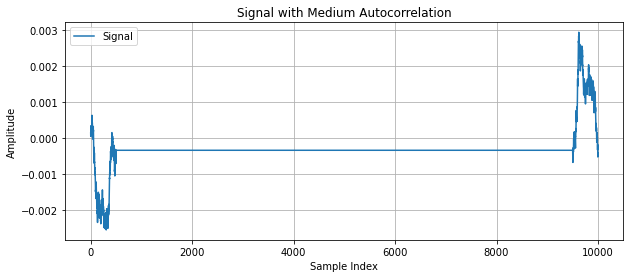

In [39]:
def generate_signal(length=1000, correlation_window=10):
    """
    Generates a signal with medium autocorrelation.

    Parameters:
        length (int): Length of the signal.
        correlation_window (int): Size of the window for the moving average to control correlation strength.

    Returns:
        np.ndarray: Signal with medium autocorrelation.
    """
    # Generate random noise
    noise = np.random.normal(0, 1, length)
   
    # Create a moving average filter
    window = np.ones(correlation_window) / correlation_window
   
    # Apply the moving average filter to introduce correlation
    signal = np.convolve(noise, window, mode='same')
   
    return signal

# Generate the signal
signal = generate_signal(length=1000, correlation_window=10000)
noise = np.random.normal(0, 1, 1000)

# Plot the signal
plt.figure(figsize=(10, 4))
# plt.plot(np.random.normal(0, 1, 1000))
plt.plot(signal, label="Signal")
plt.title("Signal with Medium Autocorrelation")
plt.xlabel("Sample Index")
plt.ylabel("Amplitude")
plt.legend()
plt.grid()
plt.show()

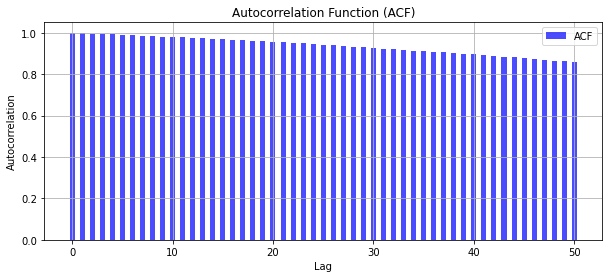

array([1.        , 0.99780294, 0.99576648, 0.99371344, 0.99144173,
       0.98930264, 0.98727239, 0.98536955, 0.98337917, 0.98142027])

In [40]:
# Calculate the ACF of the signal
lags = 50  # Number of lags to compute
autocorr_values = acf(signal, nlags=lags, fft=True)

# Plot the ACF
plt.figure(figsize=(10, 4))
plt.bar(range(lags + 1), autocorr_values, width=0.5, color='blue', alpha=0.7, label="ACF")
plt.title("Autocorrelation Function (ACF)")
plt.xlabel("Lag")
plt.ylabel("Autocorrelation")
plt.grid()
plt.legend()
plt.show()

# Display the ACF values for the first few lags
autocorr_values[:10]  # Show ACF values for lags 0 through 9

# Data Creation

In [5]:
# Set a fixed seed for reproducibility
np.random.seed(42)

# Number of variables and samples
num_var = 6
num_samples = 1000

# Generate 6 variables with the length of 1000 with medium autocorrelation
variables = [generate_signal(num_samples, 20) for _ in range(num_var)]
var = generate_signal

# Create a dataframe where each variable is a column
df = pd.DataFrame(np.column_stack(variables), columns=[f'x{i}' for i in range(1,6)] + ['y'])

# Add an 'index' column at the front, where the values are the index of the data
df.insert(0, 'index', df.index)

df.head()

,index,x1,x2,x3,x4,x5,y
0,0,0.224031,0.243654,-0.140973,-0.126137,-0.218378,-0.144191
1,1,0.200860,0.309523,-0.221351,-0.130819,-0.217247,-0.064275
2,2,0.177573,0.319403,-0.259488,-0.064529,-0.287525,-0.027597
3,3,0.189671,0.423166,-0.297945,-0.128887,-0.336774,-0.027158
4,4,0.094007,0.388707,-0.344940,-0.198743,-0.326840,-0.039042


In [18]:
help(xgb.XGBRegressor)

Help on class XGBRegressor in module xgboost.sklearn:

class XGBRegressor(XGBModel, sklearn.base.RegressorMixin)
 |  XGBRegressor(*, objective: Union[str, Callable[[numpy.ndarray, numpy.ndarray], Tuple[numpy.ndarray, numpy.ndarray]], NoneType] = 'reg:squarederror', **kwargs: Any) -> None
 |  
 |  Implementation of the scikit-learn API for XGBoost regression.
 |  See :doc:`/python/sklearn_estimator` for more information.
 |  
 |  Parameters
 |  ----------
 |  
 |      n_estimators : Optional[int]
 |          Number of gradient boosted trees.  Equivalent to number of boosting
 |          rounds.
 |  
 |      max_depth :  Optional[int]
 |          Maximum tree depth for base learners.
 |      max_leaves :
 |          Maximum number of leaves; 0 indicates no limit.
 |      max_bin :
 |          If using histogram-based algorithm, maximum number of bins per feature
 |      grow_policy :
 |          Tree growing policy. 0: favor splitting at nodes closest to the node, i.e. grow
 |          d

In [48]:
np.random.seed(42)

# Data and Target
data = df.drop(['y'], axis=1) # x1,...,x5
target = df['y']
# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=.25)


# Model Training

In [24]:
regressor = xgb.XGBRegressor(eval_metric='rmsle')

# Search for the optimal hyperparamers
param_grid = {'max_depth': [4,5,6,7],
              'n_estimators': [100,500,600,700],
              'learning_rate': [0.01,0.015,0.3]}

# Try every combination o fthe above values
search = GridSearchCV(regressor, param_grid, cv=5).fit(X_train, y_train)

print('The best hyperparameters are ', search.best_params_)

The best hyperparameters are  {'learning_rate': 0.015, 'max_depth': 7, 'n_estimators': 700}


In [25]:
# Create model instance
regressor=xgb.XGBRegressor(learning_rate = search.best_params_["learning_rate"],
                           n_estimators  = search.best_params_["n_estimators"],
                           max_depth     = search.best_params_["max_depth"],
                           eval_metric='rmsle')

regressor.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='rmsle', feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.015, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=700, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

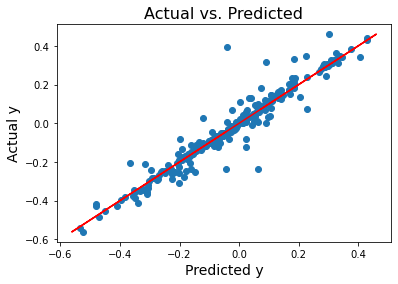

In [58]:
# Use the model to predict
predict = regressor.predict(X_test)

# Scatter plot of actual vs. predicted
plt.plot(y_test, y_test, color='red')
plt.scatter(predict, y_test)
plt.xlabel('Predicted y', fontsize=14)
plt.ylabel('Actual y', fontsize=14)
plt.title('Actual vs. Predicted', fontsize=16)
plt.show()

In [55]:
# Mean Squared Error
mse = mean_squared_error(y_test, predict)

# Root Mean Squared Error
rmse = np.sqrt(mse)

# Mean Absolute Error
mae = mean_absolute_error(y_test, predict)

# R-squared
r2 = r2_score(y_test, predict)

print(f"Test MSE : {mse:.4f}")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE : {mae:.4f}")
print(f"Test R²  : {r2:.4f}")

Test MSE : 0.0032
Test RMSE: 0.0563
Test MAE : 0.0297
Test R²  : 0.9278
